In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data_path = "/content/drive/My Drive/TATA/data"
model_path = "/content/drive/My Drive/TATA/data/models"

In [3]:
! pip install shap

     |████████████████████████████████| 327kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456467 sha256=1aa57852f13f2ca263468fce6e3a5d0dd417fe76195a03ba19643adbcd6d423b
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [4]:
# Import needed libraries
import sys
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import itertools
from decimal import *

import xgboost
import shap

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv2D, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from sklearn.preprocessing import normalize

In [142]:
labels = np.load(os.path.join(data_path, "featurelabels_real.npy"),allow_pickle = True, fix_imports=True,encoding='latin1').item()

feature_labels = np.load(os.path.join(data_path, "featurelabels_v7.npy"), fix_imports=True, encoding='latin1')[1:]

In [116]:
features = np.load(os.path.join(data_path, 'coilfeatures_v7_6.npy'), 
                   allow_pickle=True, 
                   fix_imports=True, 
                   encoding='latin1')[:, 1:]
targets = np.load(os.path.join(data_path, 'coiltargets_v7_6.npy'))

In [118]:
for f in range(features.shape[0]):
    features[f, 3] = float(features[f, 3])
    
features = features.astype(np.float64)


In [144]:
feature_labels_new = []

for f in feature_labels:
    f = f.decode('utf-8')
    if (f in labels.keys()):
        rn = labels[f].replace(" ", "_")
        feature_labels_new.append(rn)
    else:
        feature_labels_new.append(f.replace(" ", "_"))

In [119]:
features_norm = normalize(np.nan_to_num(features), norm='l2', axis=0, copy=True, return_norm=False)
# targets_norm = normalize(np.nan_to_num(targets), norm='l2', axis=0, copy=True, return_norm=True)


In [120]:
clf = keras.models.load_model(os.path.join(model_path, 'dnn_v1_hgroup_6.h5'))

In [121]:
train_data = np.expand_dims(features_norm, axis=1)
y = clf.predict(train_data)

In [167]:
n_samples = 100

# select a set of background examples to take an expectation over
background = train_data[np.random.choice(train_data.shape[0], n_samples, replace=False)]
background = np.reshape(background,(n_samples, 369))

# explain predictions of the model on four images
explainer = shap.DeepExplainer(clf, background)

td = np.reshape(train_data,(-1, 369))
shap_values = explainer.shap_values(td[1:5])

# load JS visualization code to notebook
shap.initjs()

expected_value = tf.keras.backend.get_value(explainer.expected_value)
df_td_1 = pd.DataFrame(td, columns=feature_labels_new)
df_td_2 = pd.DataFrame(td, columns=['F {}'.format(i) for i in range(1, 370)])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0][0,:], X.iloc[0,:])
sample_number = 1
shap.force_plot(expected_value, shap_values[0][sample_number], df_td_2.iloc[sample_number])

In [178]:
# load JS visualization code to notebook
shap.initjs()

# visualize the training set predictions
shap.force_plot(expected_value, shap_values[0], df_td_2, link='logit')

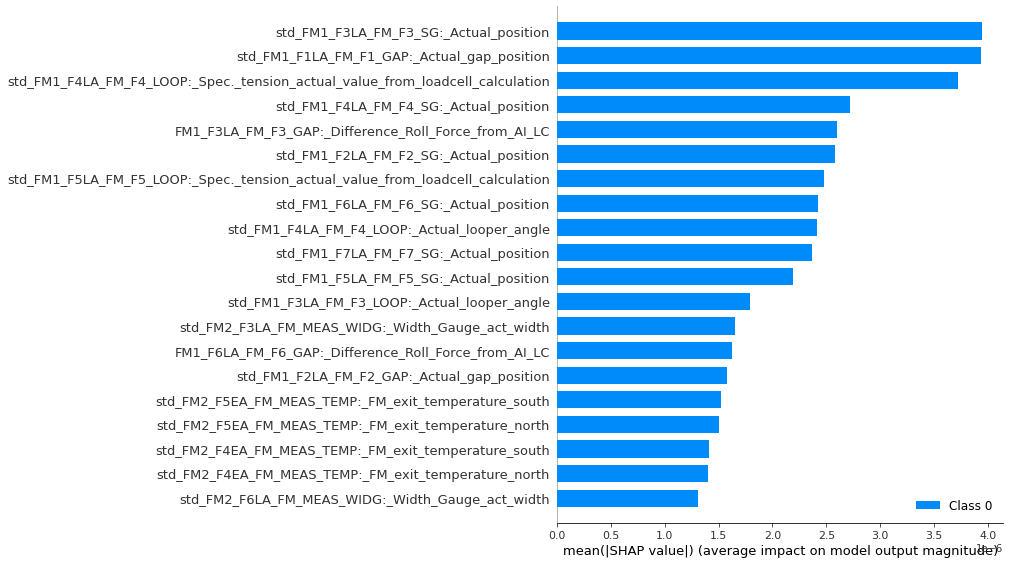

In [160]:
shap.summary_plot(shap_values, df_td_1, plot_type="bar")

In [152]:
df_td.iloc[0]

RelPos                                                             0.000000
PARAM_SET_BOTTOM_SIDE                                              0.001139
THEO_LENGTH                                                        0.002234
THEO_WIDTH                                                         0.002347
MEASURED_LENGTH-THEO                                              -0.002354
                                                                     ...   
FM2_F7LA_FM_MEAS_TG2:_Profile_Gauge_act._strip_temperature         0.001786
std_FM2_F7LA_FM_MEAS_WIDG:_Width_Gauge_act_centerline_deviation    0.001866
FM2_F7LA_FM_MEAS_WIDG:_Width_Gauge_act_centerline_deviation        0.000799
std_FM2_F7LA_FM_MEAS_WIDG:_Width_Gauge_act_width                   0.005855
FM2_F7LA_FM_MEAS_WIDG:_Width_Gauge_act_width                       0.002567
Name: 0, Length: 369, dtype: float64

In [177]:
# load JS visualization code to notebook
shap.initjs()

# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("PARAM_SET_BOTTOM_SIDE", shap_values[0], df_td_1)

IndexError: ignored

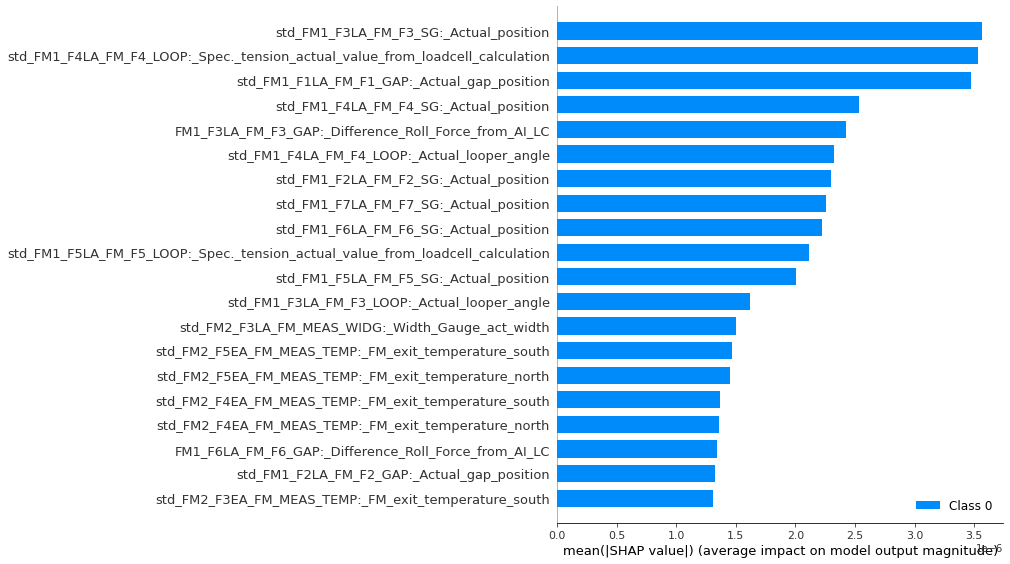

In [175]:
# summarize the effects of all the features
shap.summary_plot(shap_values, df_td_1)

In [ ]:
from keras.applications.vgg16 import preprocess_input
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
model = clf
e = shap.GradientExplainer(
    (model.input, model.output),
    map2layer(td, 1),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)


In [ ]:
# select a set of background examples to take an expectation over
n_samples = 500
background = train_data[np.random.choice(train_data.shape[0], n_samples, replace=False)]
background = np.reshape(background,(n_samples,369))

# explain predictions of the model on four images
e = shap.DeepExplainer(clf, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
td = np.reshape(train_data,(-1,369))

shap_values = e.shap_values(td[1:5])



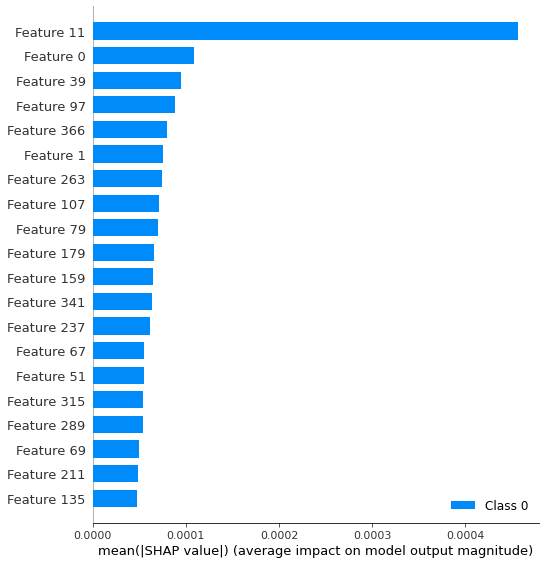

In [ ]:
shap.summary_plot(shap_values, td, plot_type="bar")

In [ ]:
shap.scatter(shap_values, td)

AttributeError: ignored

In [ ]:
shap.dependence_plot("RM", shap_values, td)

TypeError: ignored

In [ ]:
td[0].shape

(369,)

In [ ]:
e.expected_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0002141], dtype=float32)>

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
# json.dumps(a.astype(float))
shap.force_plot(e.expected_value[0], shap_values[0][0], td[0])

In [ ]:
shap_values[0][0,:]

In [ ]:
background.shape

(100, 1, 369)

In [ ]:
train_data.shape

(255900, 1, 369)

In [ ]:
features.shape

(255900, 369)